In [ ]:
# example of multioutput regression problem
# https://machinelearningmastery.com/multi-output-regression-models-with-python/

In [1]:
# check scikit-learn version
import sklearn
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df = pd.read_csv(
  "/home/jovyan/work/training_data/sw_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [2]:
df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [3]:
df.shape

(5297, 6)

In [4]:
df.head()

,sl_read1,bl_ahd1,mean_temp1,bl_ahd2,mean_temp2,rf_read1
read_date,,,,,,
2005-12-02,0.295,253.271,19.800,251.641,21.400,19.8
2005-12-03,0.303,253.277,19.825,251.644,21.350,21.4
2005-12-04,0.307,253.278,19.800,251.639,21.375,0.0
2005-12-05,0.303,253.275,19.824,251.636,21.375,0.0
2005-12-06,0.304,253.273,19.801,251.638,21.400,0.0


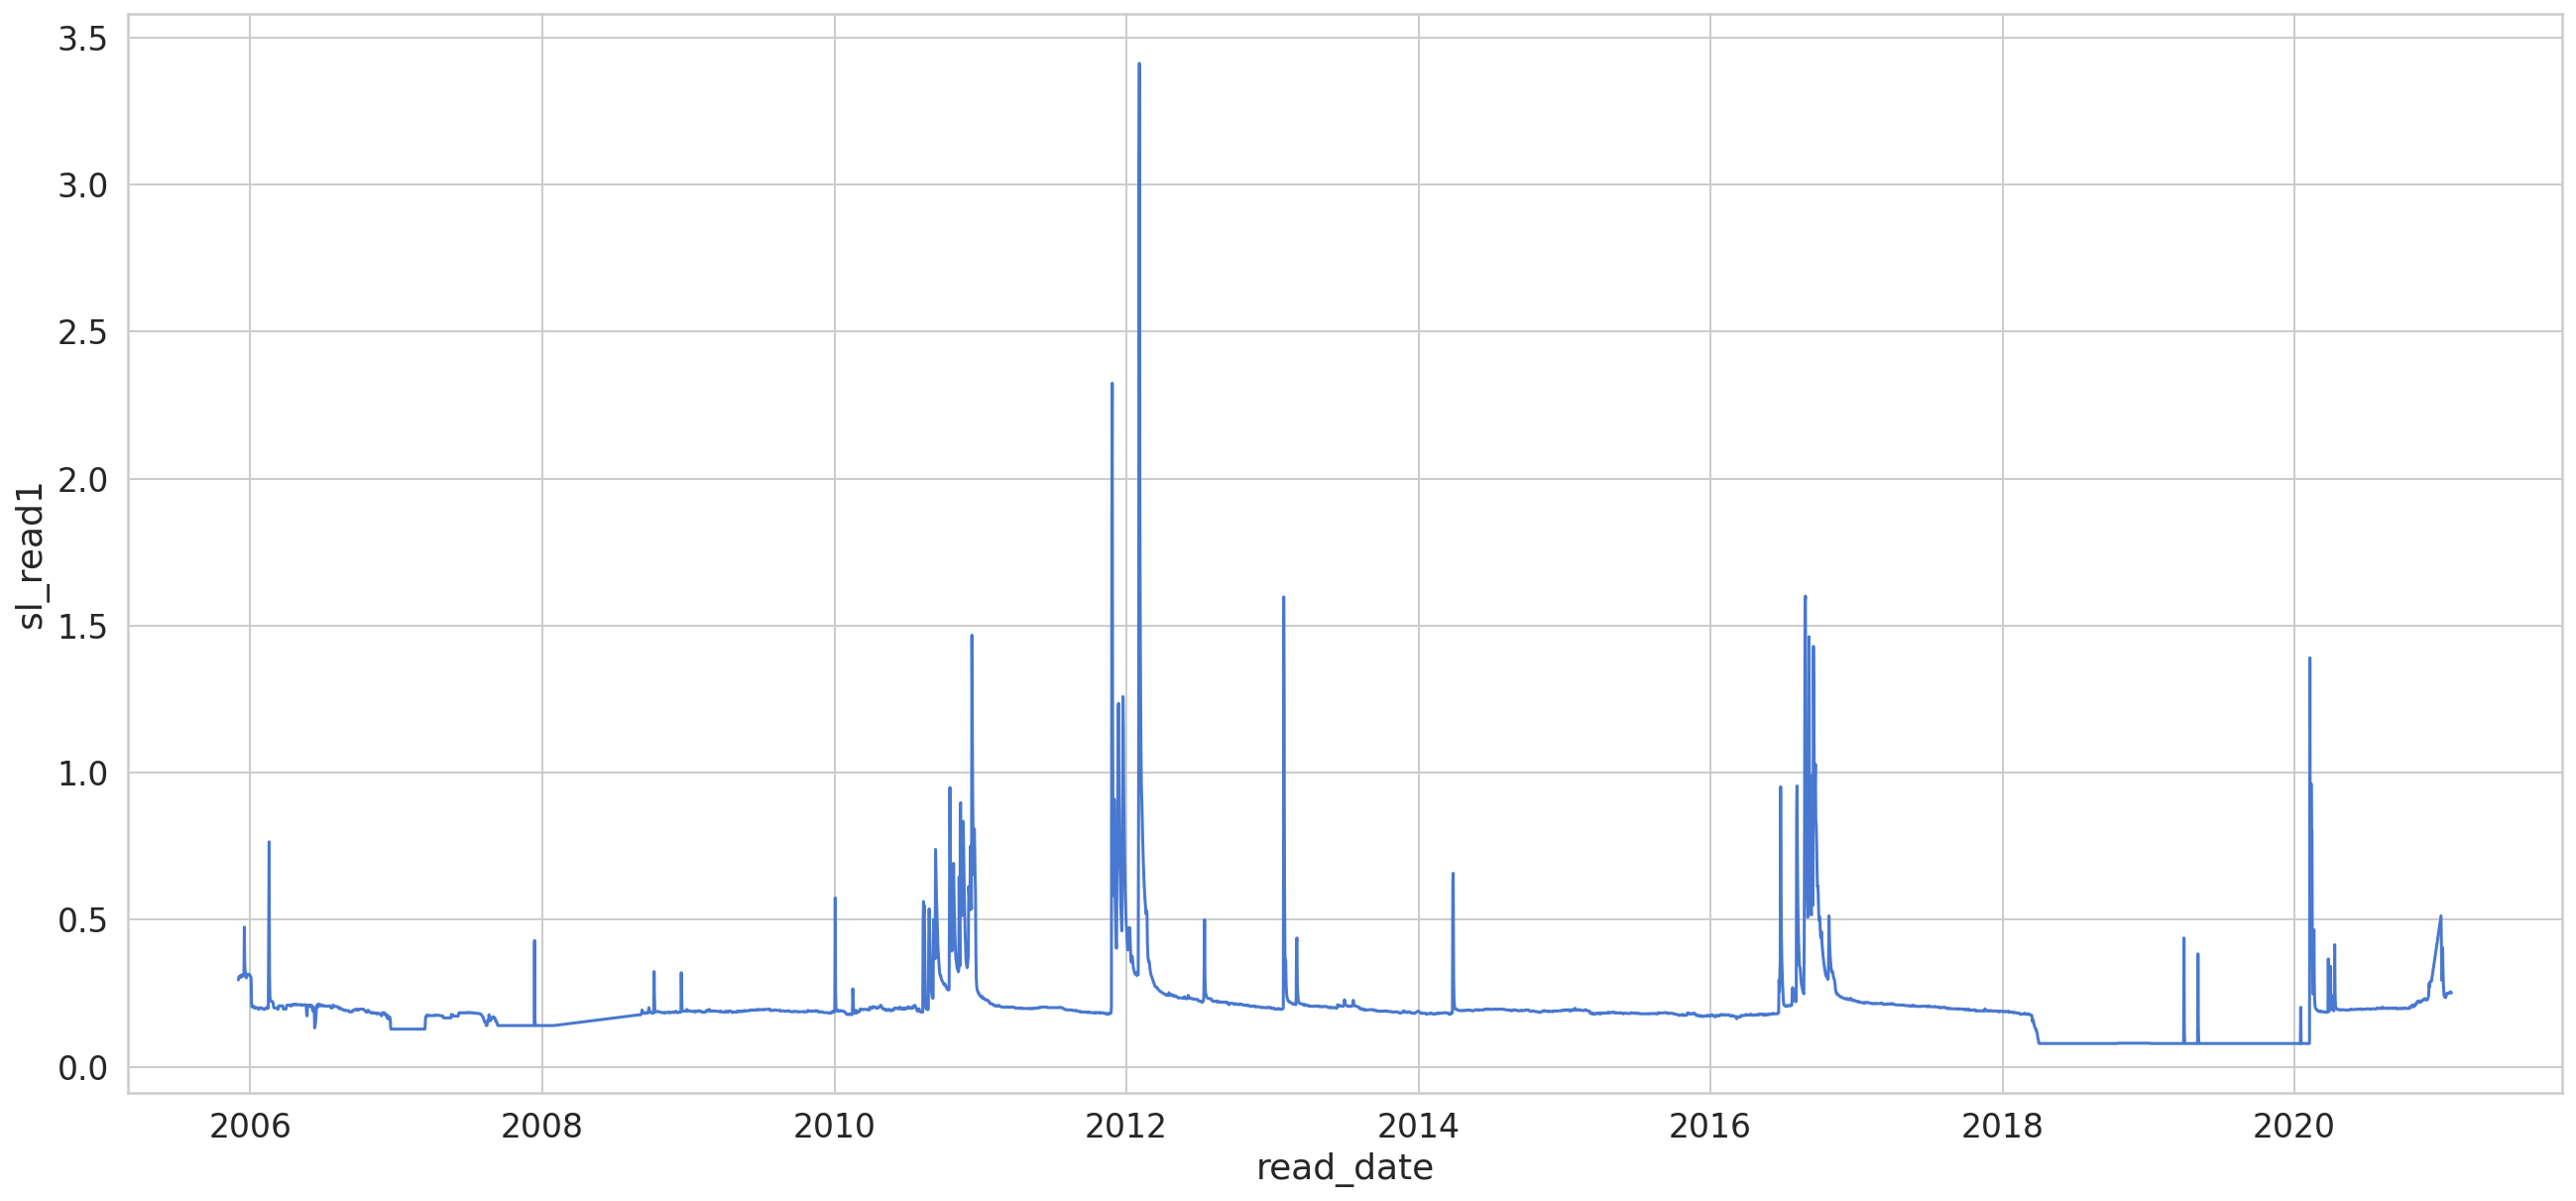

In [5]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

In [6]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
#df_test=test.copy()
print(len(train), len(test))

3972 1325


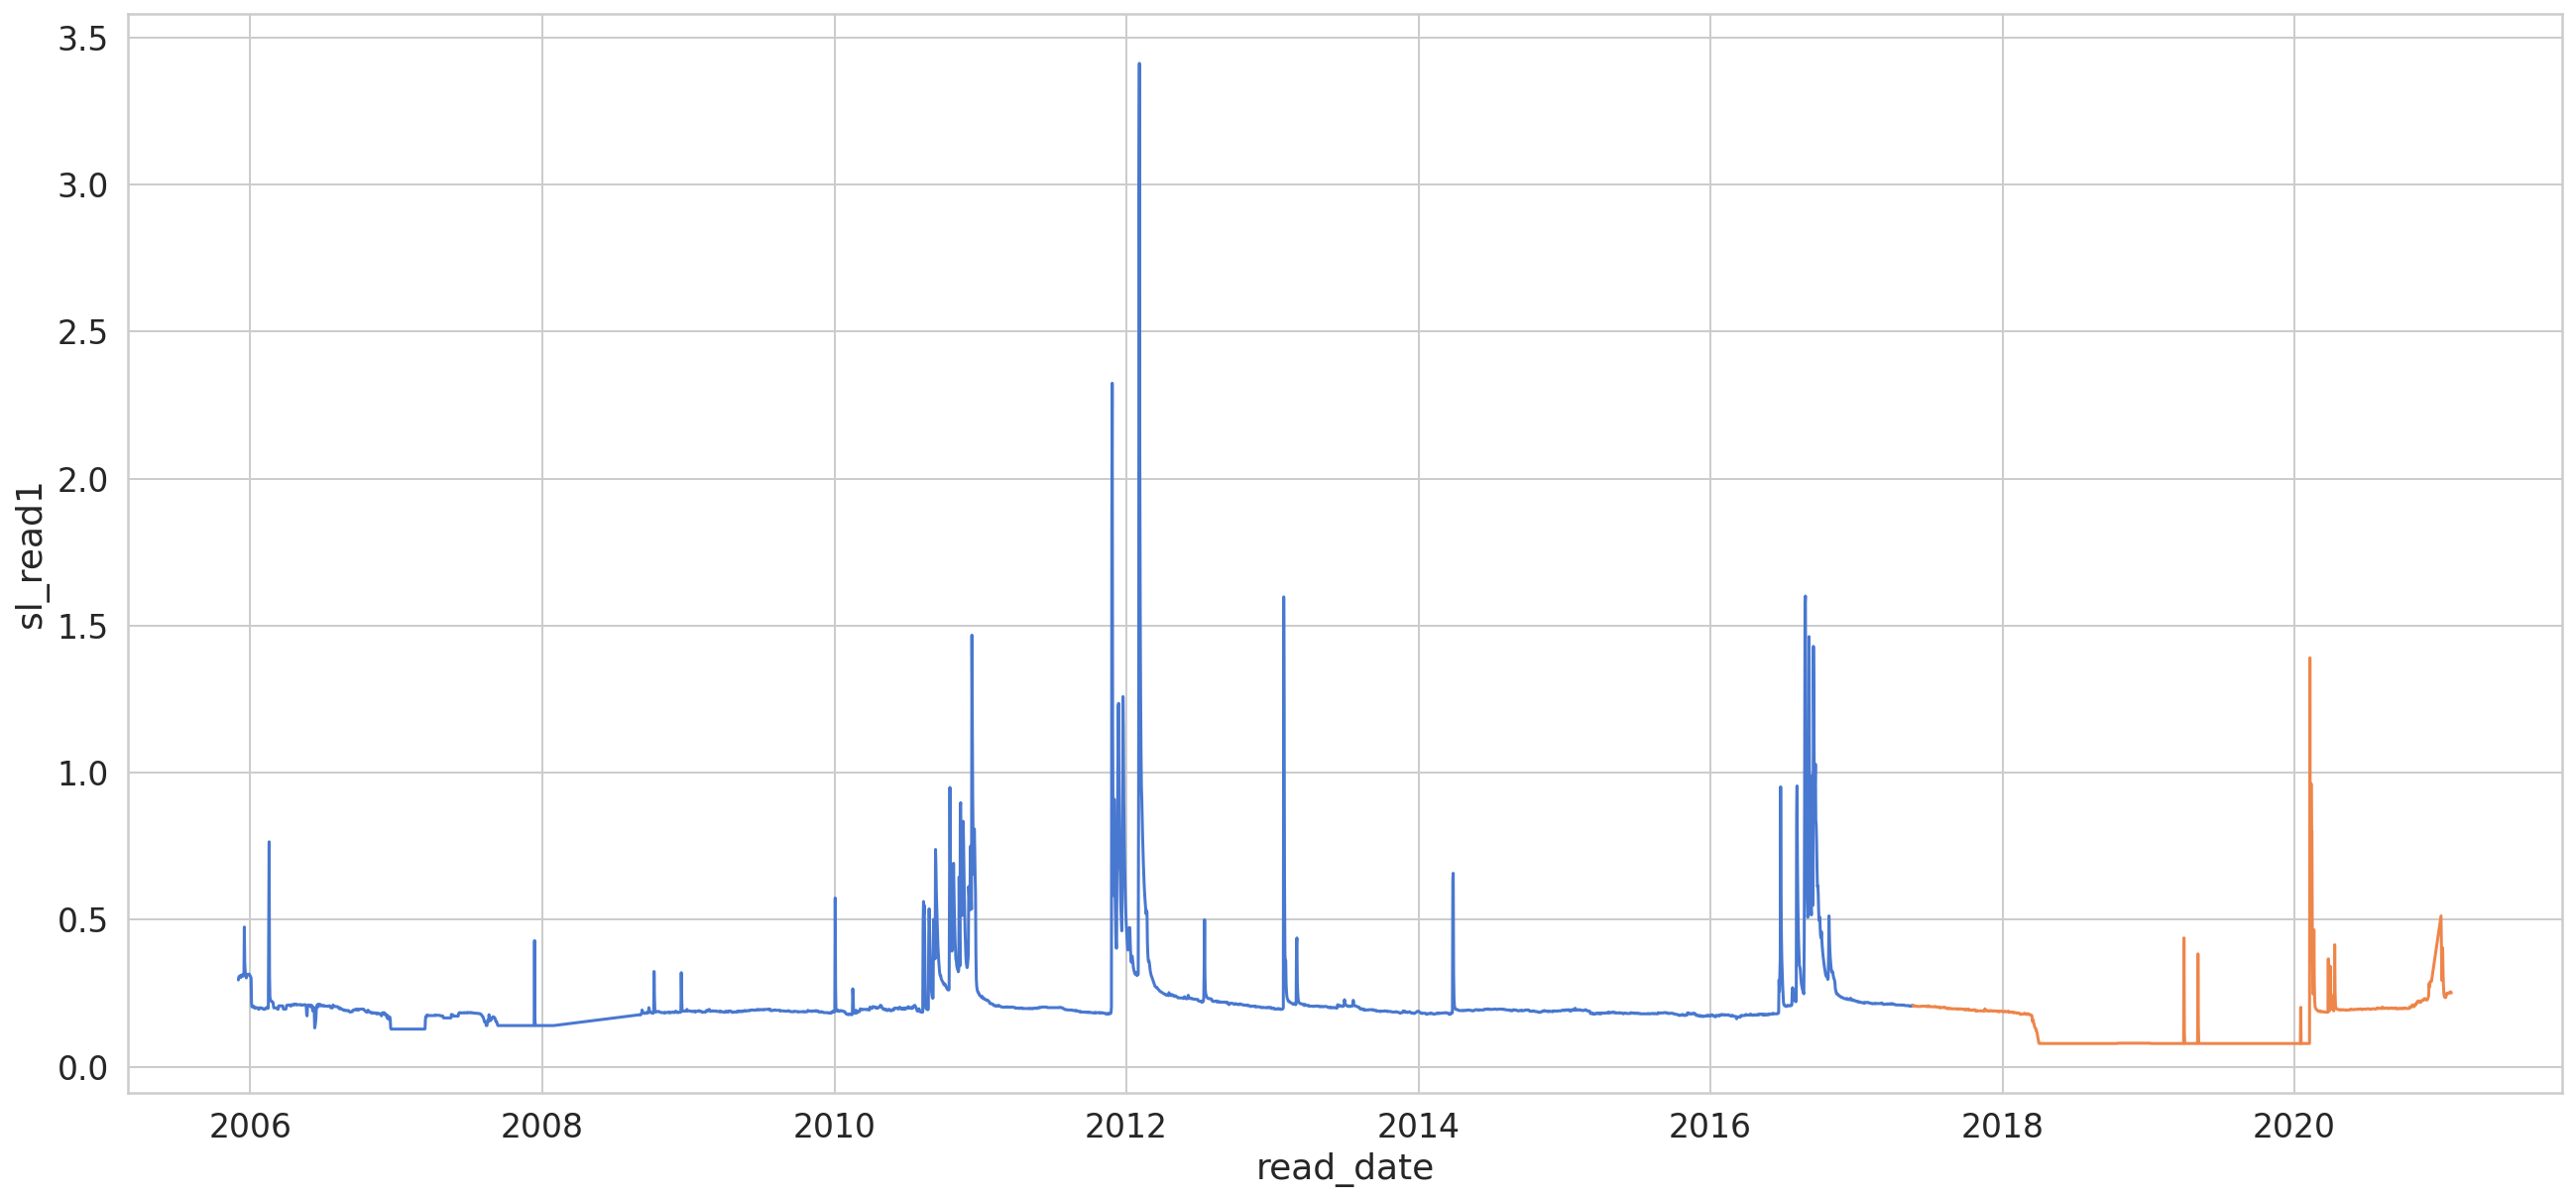

In [7]:
sns.lineplot(x=train.index, y="sl_read1", data=train);
sns.lineplot(x=test.index, y="sl_read1", data=test);

In [8]:
from sklearn.preprocessing import RobustScaler


rf_columns = ['mean_temp1','mean_temp2','rf_read1']
sl_columns = ['bl_ahd1', 'bl_ahd2','sl_read1']

rf_transformer = RobustScaler()
sl_transformer = RobustScaler()

rf_transformer = rf_transformer.fit(train[rf_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[sl_columns].to_numpy())

train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
train.loc[:, sl_columns] = sl_transformer.transform(train[sl_columns].to_numpy())

test.loc[:, rf_columns] = rf_transformer.transform(test[rf_columns].to_numpy())
test.loc[:, sl_columns] = sl_transformer.transform(test[sl_columns].to_numpy())

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-8-7408d91ff0aa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc.

In [10]:
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 10


# reshape to [samples, time_steps, n_features]

# X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
# X_test, y_test = create_dataset(test, test.sl_read1, time_steps)

X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
X_test, y_test = create_dataset(test,test.sl_read1, time_steps)

# print(X_train)
# print(y_train)

print(X_train.shape, y_train.shape)

(3962, 10, 6) (3962,)


In [16]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
112/112 [==============================] - 5s 19ms/step - loss: 16.3372 - val_loss: 44.6526
Epoch 2/30
112/112 [==============================] - 2s 14ms/step - loss: 12.0669 - val_loss: 36.7181
Epoch 3/30
112/112 [==============================] - 2s 14ms/step - loss: 10.7513 - val_loss: 35.1009
Epoch 4/30
112/112 [==============================] - 2s 14ms/step - loss: 9.9688 - val_loss: 34.2478
Epoch 5/30
112/112 [==============================] - 2s 15ms/step - loss: 9.7100 - val_loss: 27.9150
Epoch 6/30
112/112 [==============================] - 1s 13ms/step - loss: 8.8510 - val_loss: 26.5300
Epoch 7/30
112/112 [==============================] - 2s 15ms/step - loss: 8.4191 - val_loss: 21.1232
Epoch 8/30
112/112 [==============================] - 1s 13ms/step - loss: 9.2828 - val_loss: 22.4741
Epoch 9/30
112/112 [==============================] - 2s 14ms/step - loss: 8.0985 - val_loss: 24.7333
Epoch 10/30
112/112 [==============================] - 2s 14ms/step - loss: 8.0

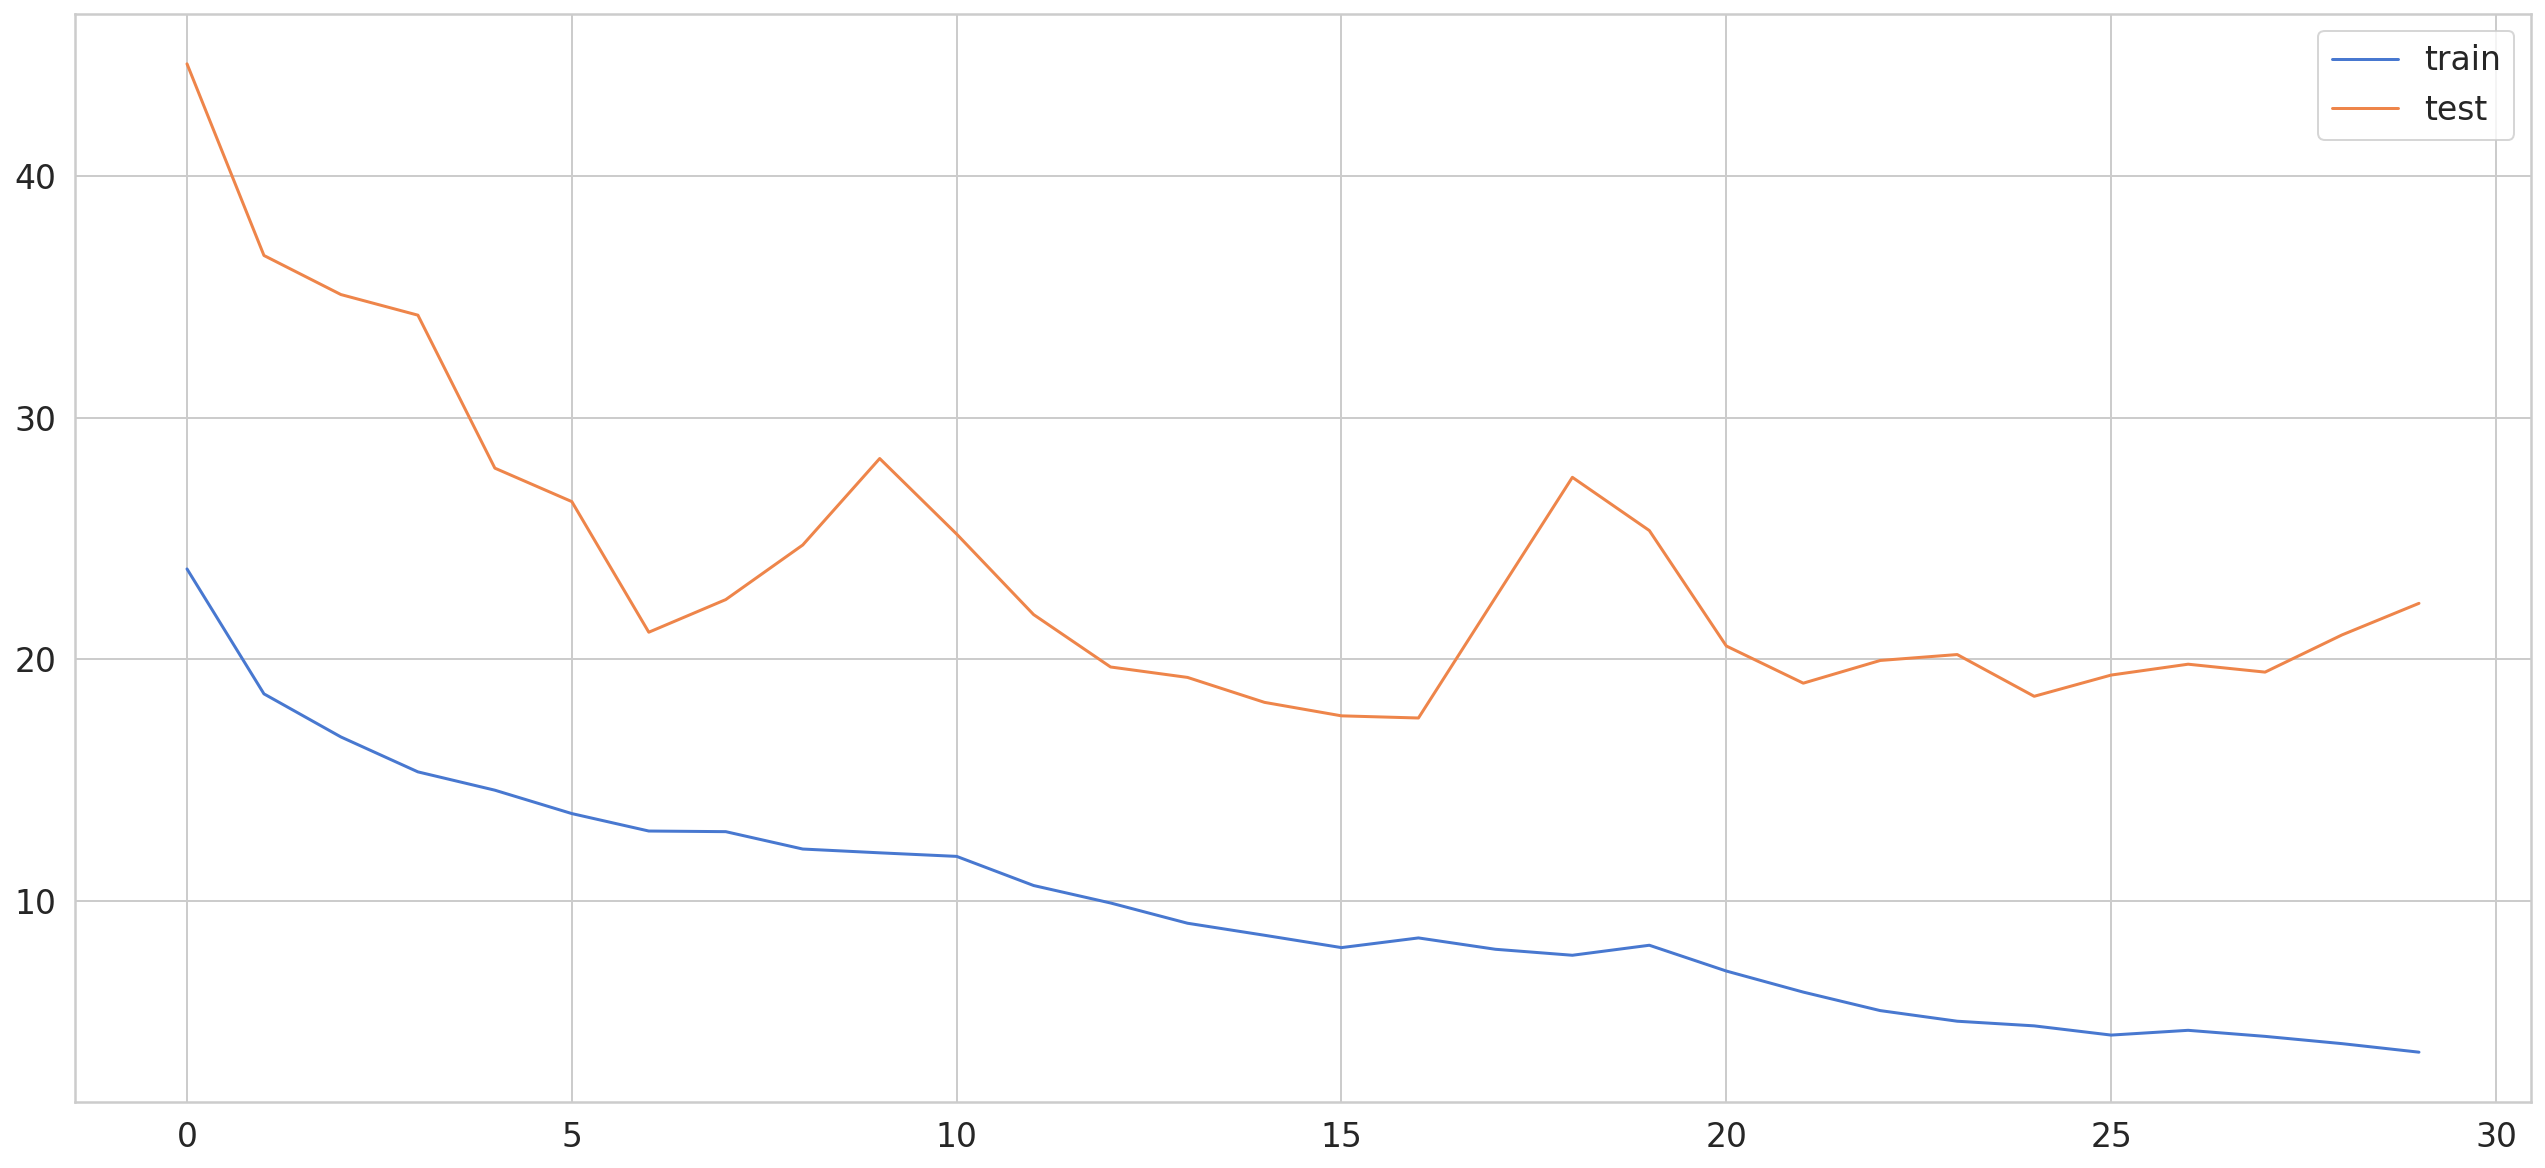

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [19]:
y_pred = model.predict(X_test)

In [20]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

ValueError: operands could not be broadcast together with shapes (1,3962) (3,) (1,3962) 

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();